In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os 

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim


from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


In [2]:
gamma  = np.load("/home/jua/corsika/run/energy_var/npz/0501/gamma_nbins41_all.npz")
proton = np.load("/home/jua/corsika/run/energy_var/npz/0501/proton_nbins41_all.npz")

In [3]:
gim = gamma['arr_0']
gen = gamma['arr_1']
pim = proton['arr_0']
pen = proton['arr_1']

In [4]:
print(len(gim),len(pim))

125371 170094


In [5]:
# binHit upper만 binHitAll upper & lower
pbinHit = [[[],[]] for i in range(10)]
gbinHit = [[[],[]] for i in range(10)]
pbinHitAll = [[[],[]] for i in range(10)]
gbinHitAll = [[[],[]] for i in range(10)]

In [6]:
perPMTHit = [6.7,10.5,16.2,24.7,35.6,48.5,61.8,74.0,85.0,100.0]

In [7]:
#pmt upper만 가지고한 것
n = len(gim)
for imu, im, en in zip(gim[:,0][:n],gim[:n],gen[:n]):
    percent = len(imu[imu!=0])*100/(41.0*41.0)
    for i in range(9):
        if perPMTHit[i] < percent < perPMTHit[i+1]:
            gbinHit[i][0].append(im)
            gbinHit[i][1].append(en)

In [8]:
#pmt upper lower 전부
n = len(gim)
for imu, iml, im, en in zip(gim[:,0][:n],gim[:,3][:n], gim[:n], gen[:n]):
    percent = (len(imu[imu!=0])+len(iml[iml!=0]))*100/(41.0*41.0*2)
    for i in range(9):
        if perPMTHit[i] < percent < perPMTHit[i+1]:
            gbinHitAll[i][0].append(im)
            gbinHitAll[i][1].append(en)

In [9]:
#pmt upper만 가지고한 것
n = len(pim)
for imu, im, en in zip(pim[:,0][:n],pim[:n], pen[:n]):
    percent = len(imu[imu!=0])*100/(41.0*41.0)
    for i in range(9):
        if perPMTHit[i] < percent < perPMTHit[i+1]:
            pbinHit[i][0].append(im)
            pbinHit[i][1].append(en)

In [10]:
#pmt upper lower 전부
n = len(pim)
for imu, iml, im, en in zip(pim[:,0][:n], pim[:,3][:n], pim[:n], pen[:n]):
    percent = (len(imu[imu!=0])+len(iml[iml!=0]))*100/(41.0*41.0*2)
    for i in range(9):
        if perPMTHit[i] < percent < perPMTHit[i+1]:
            pbinHitAll[i][0].append(im)
            pbinHitAll[i][1].append(en)

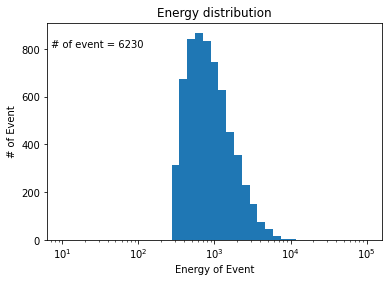

In [11]:
x = pbinHitAll[0][1]
fig, ax = plt.subplots()
b = 40
logbins = np.logspace(np.log10(10),np.log10(100000),b)
n, bins, patches = ax.hist(x,bins=logbins)

plt.xscale('log')
ax.set(title='Energy distribution')
ax.set_xlabel('Energy of Event')
ax.set_ylabel('# of Event')
ax.text(0.15, 0.9, r'# of event = %i' %(len(x)), alpha=1,
         va="center", ha="center", size=10, transform=ax.transAxes)
plt.show()

In [12]:
def plotting(histoBin, particle, arr, upperlower, Bin, c):
    numEvt = []
    logbins = np.logspace(np.log10(10),np.log10(100000),histoBin)
    fig, ax = plt.subplots(1,Bin,figsize=(7*Bin,5))
    for i in range(Bin):
        x = arr[i][1]
        numEvt.append(len(x))
        n, bins, patches = ax[i].hist(x, bins=logbins, color=c)
        ax[i].set(title='Energy distribution (B={})'.format(i+1))
        ax[i].set_xlabel('Energy of Event [GeV]')
        ax[i].set_ylabel('# of Event')
        ax[i].text(0.16, 0.9, r'# of event = %i' %(len(x)), alpha=1,
             va="center", ha="center", size=10, transform=ax[i].transAxes)
        ax[i].set_xscale('log')
    plt.savefig('plots/energy_distribution/{}_{}_energy_distribution.png'.format(particle,upperlower))
    plt.show()
    print('# of Event : ',numEvt)

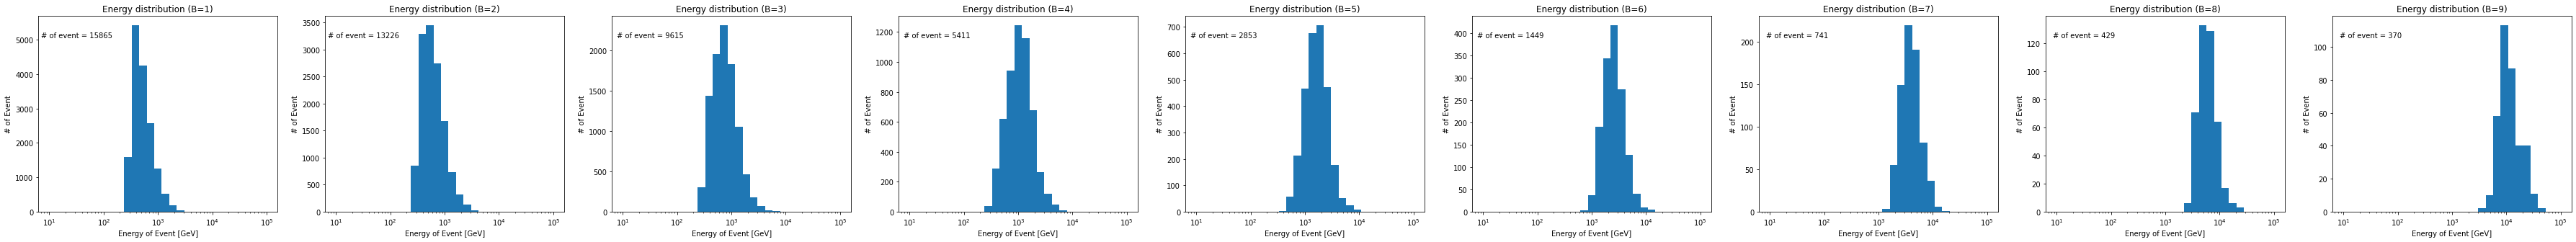

# of Event :  [15865, 13226, 9615, 5411, 2853, 1449, 741, 429, 370]


In [13]:
plotting(30, 'gamma', gbinHit, 'upper', 9, 'tab:blue')

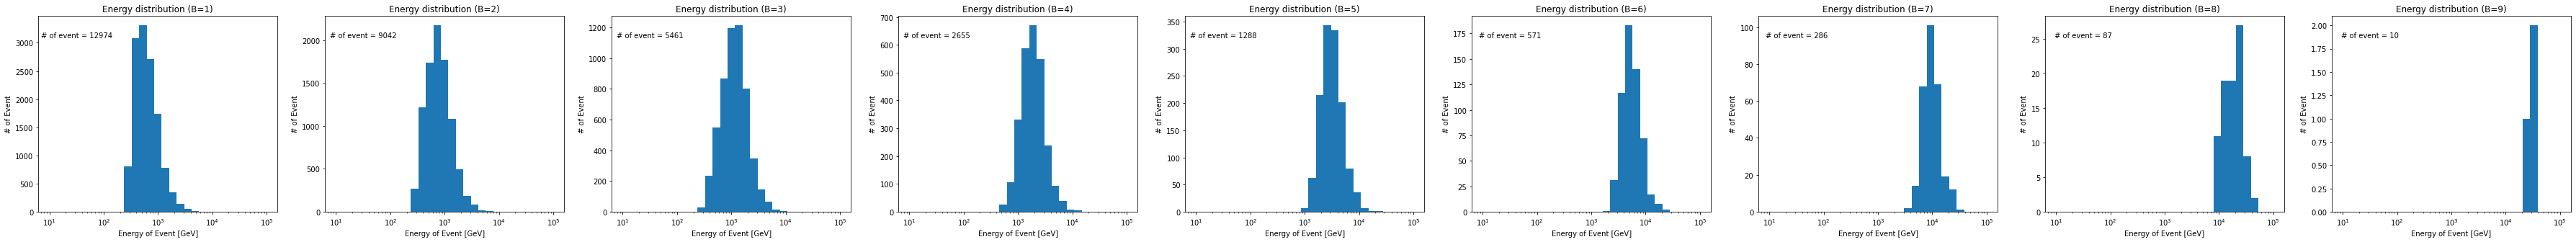

# of Event :  [12974, 9042, 5461, 2655, 1288, 571, 286, 87, 10]


In [14]:
plotting(30, 'gamma', gbinHitAll, 'All', 9, 'tab:blue')

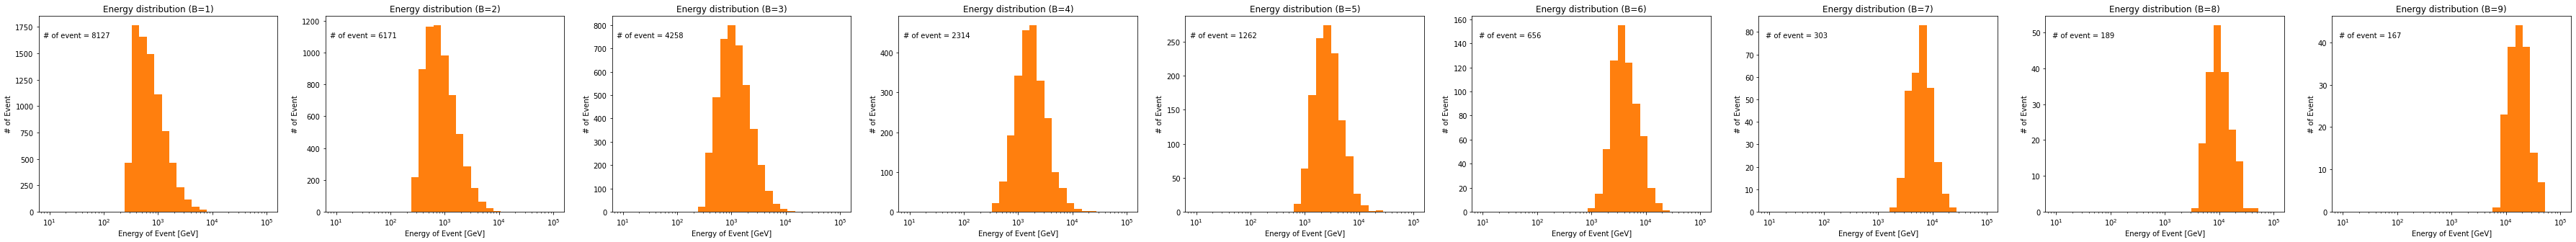

# of Event :  [8127, 6171, 4258, 2314, 1262, 656, 303, 189, 167]


In [15]:
plotting(30, 'proton', pbinHit, 'upper', 9, 'tab:orange')

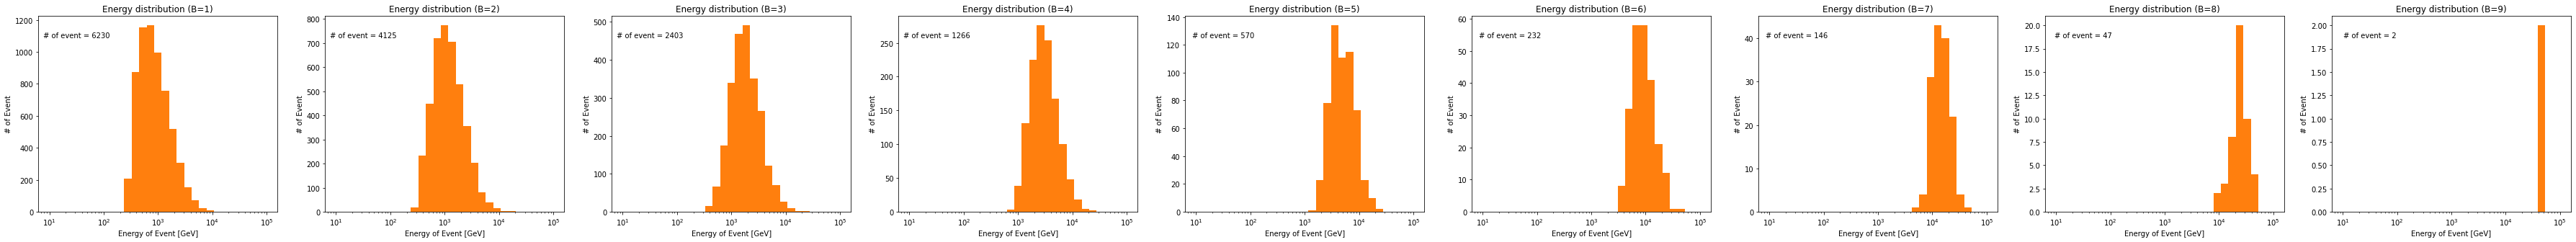

# of Event :  [6230, 4125, 2403, 1266, 570, 232, 146, 47, 2]


In [16]:
plotting(30, 'proton', pbinHitAll, 'All', 9, 'tab:orange')

In [18]:
for i in range(9):
    gbinHitAll[i][0] = np.asarray(gbinHitAll[i][0])
    gbinHitAll[i][1] = np.asarray(gbinHitAll[i][1])
    pbinHitAll[i][0] = np.asarray(pbinHitAll[i][0])
    pbinHitAll[i][1] = np.asarray(pbinHitAll[i][1])
    np.savez_compressed('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin{}_all.npz'.format(i+1),
                    image=np.asarray(gbinHitAll[i][0]),energy=np.asarray(gbinHitAll[i][1]))
    np.savez_compressed('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin{}_all.npz'.format(i+1),
                    image=np.asarray(pbinHitAll[i][0]),energy=np.asarray(pbinHitAll[i][1]))

In [ ]:
bin1 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin1_all.npz')
bin2 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin2_all.npz')

In [ ]:
gbin1 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/gamma_energy_bin1_all.npz')
pbin1 = np.load('/home/jua/corsika/run/energy_var/npz/0501/bin/proton_energy_bin1_all.npz')

In [ ]:
len(gbin1['image'])

In [ ]:
len(pbinHitAll[0][0])